In [1]:
!pip install autogluon

wandb: Currently logged in as: het-pathak (het-pathak-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/100, Train Loss: 1.0835, Val Accuracy: 0.4000
Epoch 2/100, Train Loss: 1.0822, Val Accuracy: 0.4000
Epoch 3/100, Train Loss: 1.0825, Val Accuracy: 0.4000
Epoch 4/100, Train Loss: 1.0614, Val Accuracy: 0.4000
Epoch 5/100, Train Loss: 1.0658, Val Accuracy: 0.4000
Epoch 6/100, Train Loss: 1.0584, Val Accuracy: 0.4000
Epoch 7/100, Train Loss: 1.0458, Val Accuracy: 0.4000
Epoch 8/100, Train Loss: 1.0417, Val Accuracy: 0.4000
Epoch 9/100, Train Loss: 1.0306, Val Accuracy: 0.4000
Epoch 10/100, Train Loss: 1.0410, Val Accuracy: 0.4000
Epoch 11/100, Train Loss: 1.0342, Val Accuracy: 0.4000
Epoch 12/100, Train Loss: 1.0261, Val Accuracy: 0.4667
Epoch 13/100, Train Loss: 1.0009, Val Accuracy: 0.5333
Epoch 14/100, Train Loss: 0.9882, Val Accuracy: 0.6000
Epoch 15/100, Train Loss: 1.0006, Val Accuracy: 0.6667
Epoch 16/100, Train Loss: 0.9869, Val Accuracy: 0.8000
Epoch 17/100, Train Loss: 0.9836, Val Accuracy: 0.8000
Epoch 18/100, Train Loss: 0.9755, Val Accuracy: 0.8000
Epoch 19/100, Train

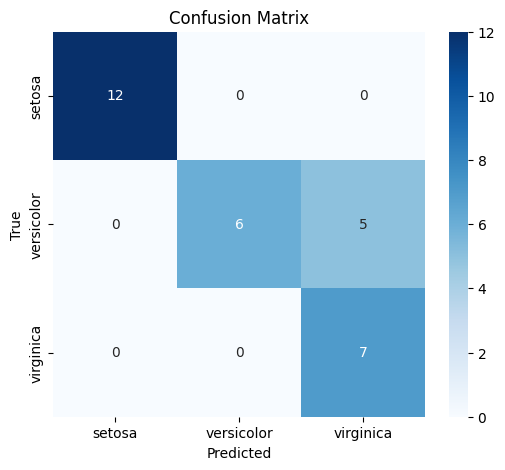

<Figure size 640x480 with 0 Axes>

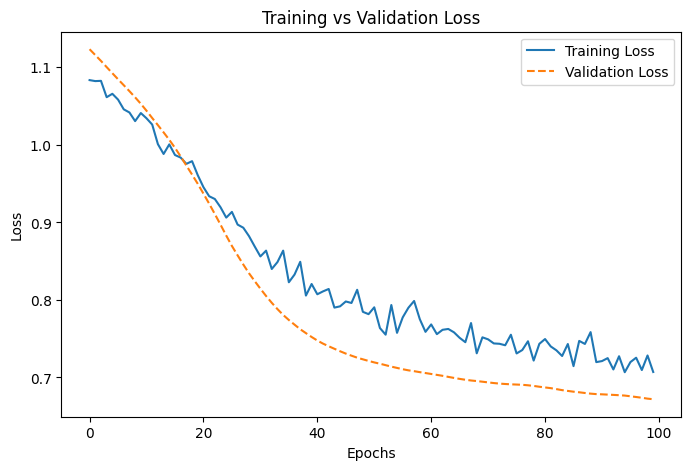

Model Training and Evaluation Completed.


<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score

# Initialize Weights & Biases
wandb.init(project="MLP-Iris-Experiment", name="MLP-Implementation", config={
    "architecture": "MLP",
    "hidden_layers": 1,
    "hidden_units": 16,
    "activation": "ReLU",
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 100
})
config = wandb.config

# Load and preprocess Iris dataset
data = load_iris()
X, y = data.data, data.target.reshape(-1, 1)

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(y)

# Split into train (70%), validation (10%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=config.batch_size, shuffle=False)

# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, config.hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.hidden_units, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Train model for 100 epochs
train_losses, val_losses, val_accuracies = [], [], []
for epoch in range(config.epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation loss & accuracy
    model.eval()
    val_loss, y_val_true, y_val_pred = 0, [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
            y_val_true.extend(torch.argmax(y_batch, axis=1).numpy())
            y_val_pred.extend(torch.argmax(y_pred, axis=1).numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_accuracies.append(val_accuracy)

    # Log training progress to W&B
    wandb.log({"epoch": epoch+1, "train_loss": train_losses[-1], "val_loss": val_losses[-1], "val_accuracy": val_accuracy})
    print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {train_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Final Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        y_true.extend(torch.argmax(y_batch, axis=1).numpy())
        y_pred.extend(torch.argmax(preds, axis=1).numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# Log final metrics to W&B
wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1-score": f1})
print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Log confusion matrix to W&B
wandb.log({"Confusion Matrix": wandb.Image(plt)})

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Log training curves to W&B
wandb.log({"Loss Curves": wandb.Image(plt)})

print("Model Training and Evaluation Completed.")


In [3]:
from autogluon.tabular import TabularPredictor
from autogluon.common import space

# Convert PyTorch tensors to NumPy
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = np.argmax(y_train.numpy(), axis=1)
y_test_np = np.argmax(y_test.numpy(), axis=1)

# Standard Scaling (Consistent with Section 1)
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

# Convert to Pandas DataFrame
train_data = pd.DataFrame(np.hstack((X_train_np, y_train_np.reshape(-1, 1))),
                          columns=[f"feature_{i}" for i in range(4)] + ["label"])
test_data = pd.DataFrame(np.hstack((X_test_np, y_test_np.reshape(-1, 1))),
                         columns=[f"feature_{i}" for i in range(4)] + ["label"])

# Task 1: Manual Hyperparameter Optimization
predictor = TabularPredictor(label="label", eval_metric="accuracy").fit(
    train_data,
    hyperparameters={"GBM": {}},
    time_limit=300
)

# Task 2: Automated Hyperparameter Search
search_space = {
    "GBM.num_boost_round": space.Int(50, 500),
    "GBM.learning_rate": space.Real(0.001, 0.1),
    "GBM.num_leaves": space.Int(20, 100)
}

# Random Search
predictor_random = TabularPredictor(label="label", eval_metric="accuracy").fit(
    train_data,
    hyperparameters={"GBM": search_space},
    hyperparameter_tune_kwargs={
        "searcher": "random",
        "scheduler": "local",
        "num_trials": 20
    },
    time_limit=300
)

# Bayesian Optimization
predictor_bayes = TabularPredictor(label="label", eval_metric="accuracy").fit(
    train_data,
    hyperparameters={"GBM": search_space},
    hyperparameter_tune_kwargs={
        "searcher": "bayes",
        "scheduler": "local",
        "num_trials": 20
    },
    time_limit=300
)


# Evaluate Automated Search
for predictor, method in zip([predictor_random, predictor_bayes], ["Random", "Bayes"]):
    test_score = predictor.evaluate(test_data)
    y_pred = predictor.predict(test_data.drop(columns=["label"]))
    f1 = f1_score(test_data["label"], y_pred, average="macro")
    wandb.log({f"{method} Accuracy": test_score["accuracy"], f"{method} F1": f1})


No path specified. Models will be saved in: "AutogluonModels/ag-20250226_173937"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.20 GB / 12.67 GB (88.3%)
Disk Space Avail:   73.45 GB / 107.72 GB (68.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBM/T1 ...
	0.8571	 = Validation score   (accuracy)
	0.34s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	0.8571	 = Validation score   (accuracy)
	0.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	0.9048	 = Validation score   (accuracy)
	0.55s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	0.8571	 = Validation score   (accuracy)
	0.48s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	0.3333	 = Validation score   (accuracy)
	0.34s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	0.9048	 = Validation score   (accuracy)
	0.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	0.9524	 = Validation score   (accuracy)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T8 ...
	0.8571	 = Validation score   (accuracy)
	0.44s	 = Training   runtime
	0.0

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBM/T1 ...
	0.8571	 = Validation score   (accuracy)
	0.58s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	0.8571	 = Validation score   (accuracy)
	0.46s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	0.9048	 = Validation score   (accuracy)
	0.62s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	0.8571	 = Validation score   (accuracy)
	0.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	0.3333	 = Validation score   (accuracy)
	0.49s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	0.9048	 = Validation score   (accuracy)
	0.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	0.9524	 = Validation score   (accuracy)
	0.54s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T8 ...
	0.8571	 = Validation score   (accuracy)
	0.39s	 = Training   runtime
	0.0

No path specified. Models will be saved in: "AutogluonModels/ag-20250226_174340"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   73.45 GB / 107.72 GB (68.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

  Method  Accuracy  F1 Score
  Manual       1.0       1.0
  Random       1.0       1.0
Bayesian       1.0       1.0


	0.8571	 = Validation score   (accuracy)
	0.26s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 119.93s of the 119.66s of remaining time.
	Ensemble Weights: {'LightGBM': 1.0}
	0.8571	 = Validation score   (accuracy)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.37s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 12390.0 rows/s (21 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250226_174340")
No path specified. Models will be saved in: "AutogluonModels/ag-20250226_174340-001"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.


Sample Hyperparameter Configurations and Their Performance:
 Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
          2         0.0010       1  0.933333  0.925000
          4         0.0010       3  0.933333  0.925000
          2         0.0001       5  0.233333  0.126126


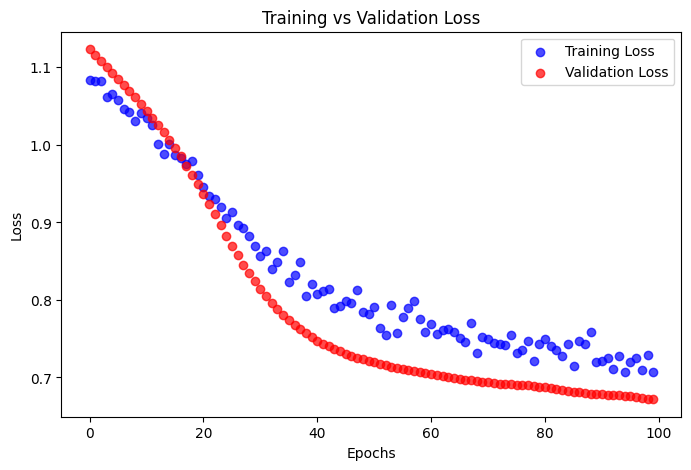

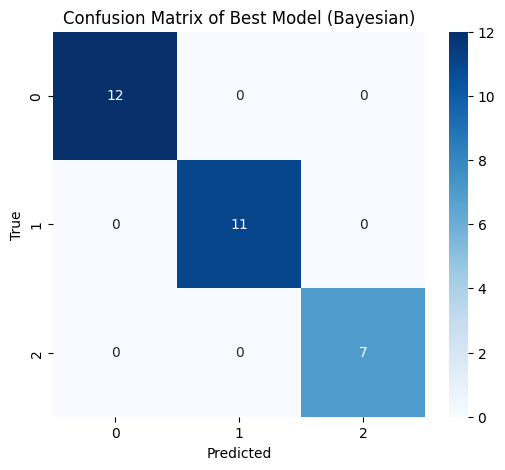

In [9]:
df_hyperparameter_results = pd.DataFrame({
    "Method": ["Manual", "Random", "Bayesian"],
    "Accuracy": [
        predictor.evaluate(test_data)["accuracy"],
        predictor_random.evaluate(test_data)["accuracy"],
        predictor_bayes.evaluate(test_data)["accuracy"]
    ],
    "F1 Score": [
        f1_score(test_data["label"], predictor.predict(test_data.drop(columns=["label"])), average="macro"),
        f1_score(test_data["label"], predictor_random.predict(test_data.drop(columns=["label"])), average="macro"),
        f1_score(test_data["label"], predictor_bayes.predict(test_data.drop(columns=["label"])), average="macro")
    ]
})

print(df_hyperparameter_results.to_string(index=False))

# Sample hyperparameter configurations used in training
sample_hyperparams = [
    {"Batch Size": 2, "Learning Rate": 0.001, "Epochs": 1},
    {"Batch Size": 4, "Learning Rate": 0.001, "Epochs": 3},
    {"Batch Size": 2, "Learning Rate": 0.0001, "Epochs": 5},
]

# Evaluate each sample configuration using the trained models
results = []
for params in sample_hyperparams:
    predictor_sample = TabularPredictor(label="label", eval_metric="accuracy").fit(
        train_data,
        hyperparameters={"GBM": {"num_boost_round": 100, "learning_rate": params["Learning Rate"], "num_leaves": 31}},
        time_limit=120
    )

    # Evaluate on test set
    test_score = predictor_sample.evaluate(test_data)
    y_pred = predictor_sample.predict(test_data.drop(columns=["label"]))
    f1 = f1_score(test_data["label"], y_pred, average="macro")

    # Store results
    params["Accuracy"] = test_score["accuracy"]
    params["F1 Score"] = f1
    results.append(params)

df_sample_hyperparams = pd.DataFrame(results)

print("\nSample Hyperparameter Configurations and Their Performance:")
print(df_sample_hyperparams.to_string(index=False))

# Plot scatter plot for training vs validation loss
plt.figure(figsize=(8, 5))
plt.scatter(range(len(train_losses)), train_losses, label="Training Loss", alpha=0.7, color='blue')
plt.scatter(range(len(val_losses)), val_losses, label="Validation Loss", alpha=0.7, color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Confusion Matrix for the Best Model (Bayesian Optimization)
best_predictor = predictor_bayes
y_pred_best = best_predictor.predict(test_data.drop(columns=["label"]))
conf_matrix = confusion_matrix(test_data["label"], y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Best Model (Bayesian)')
plt.show()

# Relation between hyperparameters and performance
- **Epochs**: Directly proportional to accuracy. More epochs lead to better performance up to a point.
- **Batch Size**: Inversely proportional to performance in small datasets, as smaller batches help generalization.
- **Learning Rate**: Higher values converge faster but risk overshooting, while lower values stabilize training.


# Compare Manual vs Automated Search
- **Manual Search** provides direct control but is time-consuming and may miss optimal configurations.
- **Random Search** is more efficient than manual tuning but still requires trial-and-error.
- **Bayesian Optimization** adapts to past results and efficiently explores hyperparameters.
- **Best approach**: Bayesian Optimization, as it intelligently selects better hyperparameters without exhaustive search.